In [1]:
%load_ext autoreload
%autoreload 2

import os
import json
import copy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import ray_results_interpreter as rri
import subprocess
import concurrent.futures
from main_run import MainRun

/user/ml4723/.conda/envs/neural_inventory_control/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/user/ml4723/.conda/envs/neural_inventory_control/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# Create vanilla results dataframe from the provided data
testset_name = "finals_n_warehouses_n_stores"

results_interpretor = rri.RayResultsinterpreter()

def custom_data_filler(out_row, reference_row):
    out_row['path'] = reference_row['path']

def default_condition_setter(condition_name):
    return None

# Define color scheme, line styles and markers
color_scheme = {
    128: "#1f77b4",    # Blue
    1024: "#2ca02c",   # Green  
    8192: "#ff7f0e",   # Orange
}

marker_scheme = {
    128: "o",          # Circle
    1024: "v",         # Down triangle
    8192: "s",         # Square
}

linestyle_scheme = {
    "Vanilla NN": "-",  # Dashed
    "GNN": "--",  # Dotted
    # "GNN_bottleneck": "-.",  # Dashed
}

# Define paths for each architecture
architectures = {
    "Vanilla NN": f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/vanilla_n_warehouses',
    "GNN": f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/GNN_selfloop',
    # "GNN_bottleneck": f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/GNN_bottleneck',
}

# Define configs for different settings
configs = [
    "n_warehouse_10_2_lost_demand",
    "n_warehouse_20_3_lost_demand",
    "n_warehouse_30_4_lost_demand", 
    "n_warehouse_40_5_lost_demand", 
    "n_warehouse_50_6_lost_demand"
]

# Map configs to their (stores, warehouses) values for plotting
config_to_stores_warehouses = {
    "n_warehouse_10_2_lost_demand": (10, 2),
    "n_warehouse_20_3_lost_demand": (20, 3),
    "n_warehouse_30_4_lost_demand": (30, 4),
    "n_warehouse_40_5_lost_demand": (40, 5),
    "n_warehouse_50_6_lost_demand": (50, 6)
}

sort_by = 'dev_loss'
pick_row_from_run_by = 'dev_loss'
sample_sizes = [128, 1024, 8192]

dfs = []

# Create dataframes for each architecture, config and sample size
for arch_name, path in architectures.items():
    for config in configs:
        for sample_size in sample_sizes:
            df = results_interpretor.make_table({1: path},
                {'train_dev_sample_and_batch_size': [sample_size],
                 'store_underage_cost': [9],
                 'config': [config],
                 'samples': [1]},
                default_condition_setter, custom_data_filler,
                sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by, test_loss_limit=25)
            if df.empty:
                continue
            
            df.insert(2, 'Architecture Class', arch_name)
            df.insert(1, 'hyperparam_name', arch_name)
            df['train_dev_sample_and_batch_size'] = sample_size
            df['config'] = config
            df['n_stores'] = config_to_stores_warehouses[config][0]
            df['n_warehouses'] = config_to_stores_warehouses[config][1]
            dfs.append(df)

# Combine all dataframes
df = pd.concat(dfs, ignore_index=True)


Error processing files in /user/ml4723/Prj/NIC/ray_results/finals_n_warehouses_n_stores/GNN_selfloop/run_2025-05-19_16-11-26/run_71ca5_00039_39_config=n_warehouse_30_4_lost_demand,dev_ignore_periods=60,dev_periods=100,different_for_each_sample=True,early__2025-05-19_16-11-28: No columns to parse from file


In [ ]:
import numpy as np

test_loss_column = 'Test Loss'

test_losses = []
for _, row in df.iterrows():
    test_loss_path = str(row['path']) +"/"+ row['config'] + "_5000_test_loss.txt"
    try:
        with open(test_loss_path, 'r') as f:
            value = float(f.read().strip())
    except Exception:
        value = np.nan
    test_losses.append(value)

df[test_loss_column] = test_losses

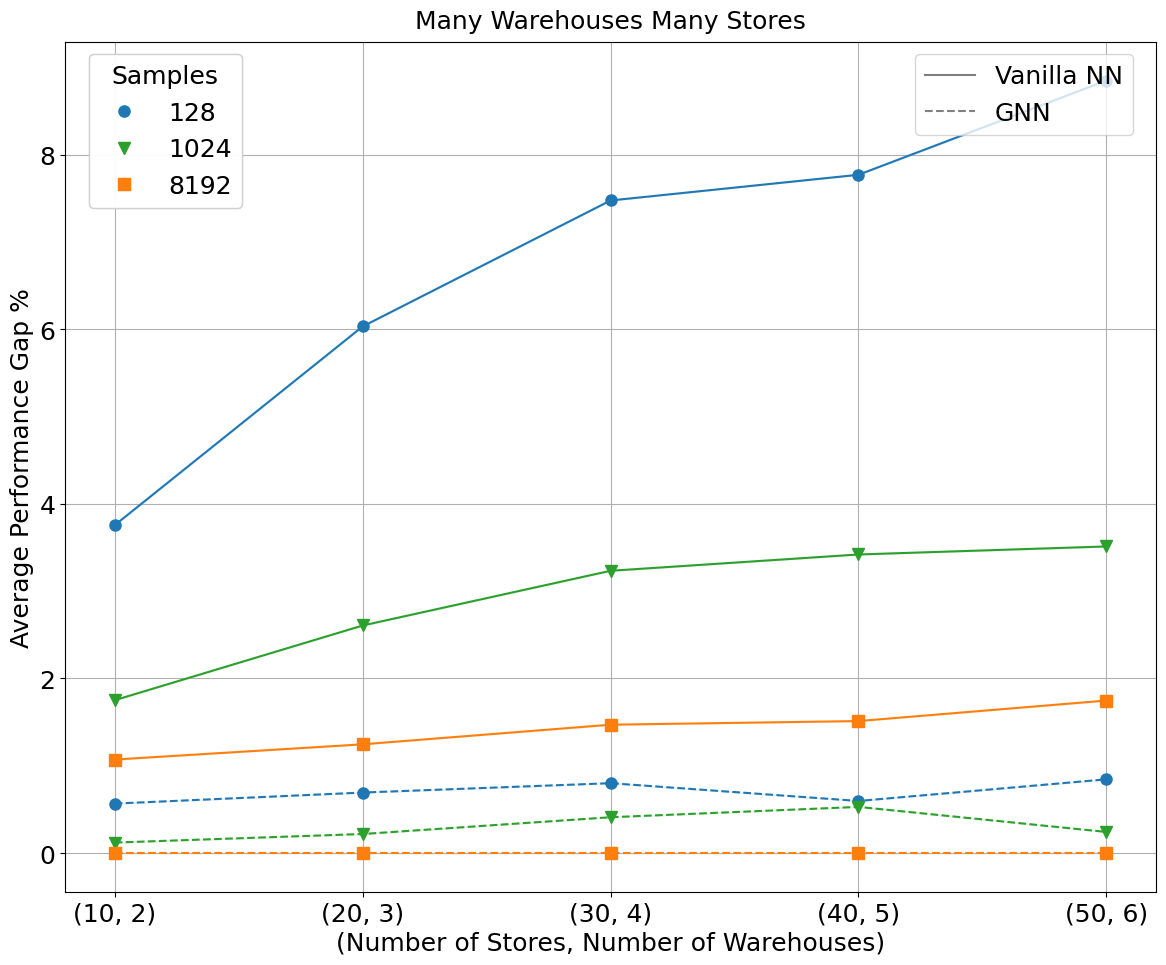

In [7]:
# Find best test loss for each config
best_losses = {}
for config in configs:
    config_data = df[df['config'] == config]
    if not config_data.empty:
        best_losses[config] = config_data['Test Loss'].min()

# Calculate performance gap percentage
stats_by_arch_sample_and_config = {}
for config in configs:
    if config not in best_losses:
        continue
        
    best_loss = best_losses[config]
    config_data = df[df['config'] == config].copy()
    
    if config_data.empty:
        continue
        
    config_data.loc[:, 'Gap %'] = ((config_data['Test Loss'] - best_loss) / best_loss) * 100
    
    for arch in config_data['Architecture Class'].unique():
        for sample_size in sample_sizes:
            key = (arch, sample_size)
            if key not in stats_by_arch_sample_and_config:
                stats_by_arch_sample_and_config[key] = []
                
            sample_data = config_data[(config_data['train_dev_sample_and_batch_size'] == sample_size) & 
                                   (config_data['Architecture Class'] == arch)]
            if not sample_data.empty:
                gaps = sample_data['Gap %'].to_numpy()
                mean_gap = np.mean(gaps)
                std_gap = np.std(gaps)
                ci_95 = 1.96 * std_gap / np.sqrt(len(gaps))
                stats_by_arch_sample_and_config[key].append({
                    'config': config,
                    'n_stores': config_to_stores_warehouses[config][0],
                    'n_warehouses': config_to_stores_warehouses[config][1],
                    'mean_gap': mean_gap,
                    'ci_lower': mean_gap - ci_95,
                    'ci_upper': mean_gap + ci_95
                })

# Create plot
FONTSIZE = 18
plt.figure(figsize=(12, 10))
plt.rcParams.update({'font.size': FONTSIZE})

# Plot lines
for (arch, sample_size), stats in stats_by_arch_sample_and_config.items():
    stats_df = pd.DataFrame(stats)
    if not stats_df.empty:
        # Sort by number of stores for proper x-axis ordering
        stats_df = stats_df.sort_values('n_stores')
        
        # Convert pandas series to numpy arrays before plotting
        n_stores_array = stats_df['n_stores'].to_numpy()
        mean_gap_array = stats_df['mean_gap'].to_numpy()
        ci_lower_array = stats_df['ci_lower'].to_numpy()
        ci_upper_array = stats_df['ci_upper'].to_numpy()
        
        plt.plot(n_stores_array, mean_gap_array,
                marker=marker_scheme[sample_size],
                color=color_scheme[sample_size],
                linestyle=linestyle_scheme[arch],
                markersize=8)
        
        plt.fill_between(n_stores_array,
                        ci_lower_array,
                        ci_upper_array,
                        color=color_scheme[sample_size],
                        alpha=0.1)

# Create separate legend entries for architectures and sample sizes
arch_lines = [plt.Line2D([0], [0], color='gray', linestyle=linestyle_scheme[arch], label=arch) 
              for arch in linestyle_scheme.keys()]
sample_patches = [plt.Line2D([0], [0], color=color_scheme[size], marker=marker_scheme[size], 
                            linestyle='none', label=f'{size}', markersize=8)
                 for size in color_scheme.keys()]

plt.xlabel('(Number of Stores, Number of Warehouses)', fontsize=FONTSIZE)
plt.ylabel('Average Performance Gap %', fontsize=FONTSIZE)
plt.grid(True)

# Create x-tick labels with (n_stores, n_warehouses) format
x_ticks = [10, 20, 30, 40, 50]
x_tick_labels = []
for n_stores in x_ticks:
    for config, (stores, warehouses) in config_to_stores_warehouses.items():
        if stores == n_stores:
            x_tick_labels.append(f"({stores}, {warehouses})")
            break

plt.xticks(x_ticks, x_tick_labels, fontsize=FONTSIZE)
plt.yticks(fontsize=FONTSIZE)

# Create two separate legends
# Right legend for architectures
legend1 = plt.legend(handles=arch_lines, 
                    bbox_to_anchor=(0.99, 1),
                    loc='upper right', 
                    fontsize=FONTSIZE)
plt.gca().add_artist(legend1)

# Left legend for sample sizes with title
legend2 = plt.legend(handles=sample_patches,
                    title='Samples',
                    bbox_to_anchor=(0.01, 1),
                    loc='upper left',
                    fontsize=FONTSIZE)
plt.gca().add_artist(legend2)
legend2.get_title().set_fontsize(FONTSIZE)

plt.title('Many Warehouses Many Stores', fontsize=FONTSIZE, pad=10)
plt.tight_layout()
plt.show()

In [5]:
mode = "test"

gpus = [0, 1, 2, 4, 5]

def run_main_run(model_path, setting_name, gpu_idx):
    try:
        # Extract hyperparam name from model path
        hyperparam_name = model_path.split('/')[7]
        print(f"Running main_run.py for path {model_path}")
        cmd = [
            "/user/ml4723/.conda/envs/neural_inventory_control/bin/python",
            "main_run.py",
            mode, # test or test_on_dev
            setting_name,
            hyperparam_name,
            str(model_path),
            str(gpus[gpu_idx])
        ]
        env = {
            **os.environ,
            "MKL_THREADING_LAYER": "GNU",
            "MKL_SERVICE_FORCE_INTEL": "1"
        }
        subprocess.run(cmd, capture_output=True, text=True, check=True, env=env, cwd="/user/ml4723/Prj/NIC/")
    except subprocess.CalledProcessError as e:
        print(f"Error running main_run.py for path {model_path}: {e}")
        print(f"Error output: {e.stderr}")
    except Exception as e:
        print(f"Unexpected error running main_run.py for path {model_path}: {e}")

with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = []
    gpu_idx = 0
    for _, row in df.iterrows():
        path = str(row['path']) + '/model.pt'
        while len(futures) >= 4*len(gpus):
            done, not_done = concurrent.futures.wait(
                futures, 
                return_when=concurrent.futures.FIRST_COMPLETED
            )
            futures = list(not_done)
        futures.append(executor.submit(run_main_run, path, row['config'] + '_5000', gpu_idx))
        gpu_idx = (gpu_idx + 1) % len(gpus)
    concurrent.futures.wait(futures)

Running main_run.py for path /user/ml4723/Prj/NIC/ray_results/finals_n_warehouses_n_stores/vanilla_n_warehouses/run_2025-05-09_21-59-58/run_79db8_00294_294_config=n_warehouse_10_2_lost_demand,dev_ignore_periods=60,dev_periods=100,different_for_each_sample=True,early_2025-05-10_12-02-48/model.pt
Running main_run.py for path /user/ml4723/Prj/NIC/ray_results/finals_n_warehouses_n_stores/vanilla_n_warehouses/run_2025-05-09_21-59-58/run_79db8_00249_249_config=n_warehouse_10_2_lost_demand,dev_ignore_periods=60,dev_periods=100,different_for_each_sample=True,early_2025-05-10_04-26-58/model.pt
Running main_run.py for path /user/ml4723/Prj/NIC/ray_results/finals_n_warehouses_n_stores/vanilla_n_warehouses/run_2025-05-09_21-59-58/run_79db8_00069_69_config=n_warehouse_10_2_lost_demand,dev_ignore_periods=60,dev_periods=100,different_for_each_sample=True,early__2025-05-09_22-00-00/model.pt
Running main_run.py for path /user/ml4723/Prj/NIC/ray_results/finals_n_warehouses_n_stores/vanilla_n_warehouses/